Wilberforce Pendulum

In [1]:
from sympy import *
from sympy.physics.mechanics import *
import sympy as sp
init_printing(use_unicode=False, wrap_line=False)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

**Part (a)** 

Solve for the equations of motion given the Lagrangian of the system

In [2]:
m,I,k,delta,epsilon = symbols('m,I,k,delta,epsilon', real = True) #Set up params as symbols for differentiation

#Use dynamic symbols from sympy to create differential terms
z   = dynamicsymbols('z')
zdot  = dynamicsymbols('z',1) #1=first derivative

theta = dynamicsymbols('theta')
thetadot = dynamicsymbols('theta', 1)

#Lagrangian for Wilberforce Pendulum
L = 0.5 * ( m*zdot**2 + I*thetadot**2 - k*z**2 - delta*theta**2 - epsilon*z*theta )

#Find equations of motion with Euler-Lagrange equations for z and theta coordinates
Expr_z = diff(diff(L, zdot), 't') - diff(L, z)
Expr_theta = diff(diff(L, thetadot), 't') - diff(L, theta)

In [3]:
#Left side of Euler-Lagrange equations
pprint(Expr_z)
pprint(Expr_theta)

                                            2      
                                           d       
0.5*epsilon*theta(t) + 1.0*k*z(t) + 1.0*m*---(z(t))
                                            2      
                                          dt       
        2                                                  
       d                                                   
1.0*I*---(theta(t)) + 1.0*delta*theta(t) + 0.5*epsilon*z(t)
        2                                                  
      dt                                                   


Transform Euler-Lagrange equations for each coordinate into ready-to-use inputs for rk4

In [4]:
EL_z = sp.Eq(Expr_z, 0) #Set right side of EL equations equal to 0
zdd = sp.solve(EL_z,Derivative('z(t)', '(t,2)')) #Isolates Z double-dot or 2nd derivative of z
zdd = zdd[0] #Removes expression from list
print(zdd)
zdd = sp.lambdify([z,theta,k,m,epsilon],zdd,"numpy") #Lambdify changes symbols to python variable inputs

-(0.5*epsilon*theta(t) + k*z(t))/m


In [5]:
EL_theta = sp.Eq(Expr_theta, 0)
thetadd = sp.solve(EL_theta,Derivative('theta(t)', '(t,2)'))
thetadd = thetadd[0]
thetadd = sp.lambdify([z,theta,I,delta,epsilon],thetadd,"numpy")

**Part (b)** 

Compute z(t) and $\theta (t)$ using rk4 (runge-kutta 4th order) and create a plot of each variable vs. time. 

Initial conditions:
1. $z(0) = 10 \ cm$, $\theta (0) = 0 \ rad$
2. $z(0) = 0 \ cm$, $\theta (0) = 2\pi \ rad$

In [6]:
#Tailored version of rk4 for problem
def rk4(x,tau,derivs):
    """
    x = state input
    tau = time step
    derivs = derivs(state) which returns n-array of derivatives from initial n-state vector
    """
    
    half_tau = 0.5*tau
    k1 = derivs(x)  #If state is sub into x for rk4, this will read derivs(state)
    
    xtemp = x + half_tau*k1
    k2 = derivs(xtemp)  
    
    xtemp = x + half_tau*k2
    k3 = derivs(xtemp)
    
    xtemp = x + tau*k3
    k4 = derivs(xtemp)
    
    xout = x + tau/6.*(k1 + k4 + 2.*(k2+k3))
    return xout

In [7]:
#Outputs derivative of every index value in state vector
def derivs(s):
   
    #z and theta saved from state vector at current step to sub into equations of motion
    z = s[0] 
    theta = s[1]
    
    #Saves 1st derivs in state vector
    zdot = s[2]
    thdot = s[3]
    
    #Equations of motion, calculates 2nd derivs numerically at each step
    dzdt2 = zdd(z,theta,k,m,epsilon)
    dthdt2 = thetadd(z,theta,I,delta,epsilon)
    
    #Returns temporary state vector to be iterated through rk4
    derivs = np.array([zdot,thdot,dzdt2,dthdt2])
    return derivs

In [11]:
#Enter initial conditions
z0 = eval(input('Initial position in z (cm): '))/100 #converts cm to m
theta0 = eval(input('Initial azimuthal angle (rad): '))
state = np.array([z0, theta0, 0, 0])  #zeros in place of 1st derivs

# Set physical parameters
m = 0.5 #kg
I = 1e-4 #kgm^2
k = 5 #N/m
delta = 1e-3 #N*m
epsilon = 1e-2 #N

#Set time counter, time step, and periods for z and theta
time = 0.0 
tau = eval(input('Enter time step (s): '))
z_T = 2*np.pi*(np.sqrt(m/k)) #period in z
theta_T = 2*np.pi*(np.sqrt(I/delta)) #period in theta

zwavepacket_T = 14.5*z_T #Only valid with torsional and vertical frequences EQUAL, 14.5 cycles per wavepacket or 'beat'
print('Beat Period in z is: ',zwavepacket_T,'seconds')
N = int(2*zwavepacket_T/tau) #Steps for 2 periods

#Create empty arrays for plotting z,theta,t
zplot = np.empty(N)
thplot = np.empty(N)
tplot = np.empty(N)

#Loop through data
for i in (range(N)):
    
    #Saves each iteration
    zplot[i] = state[0]  
    thplot[i] = state[1]
    tplot[i] = time
    #Subs state into rk4 to return new state(z,theta,dz_dt,dtheta_dt)
    state = rk4(state, tau, derivs)
    time += tau

#Define vertical and torsional frequencies, remove 1/2pi normalization factor
f_z = np.sqrt(k/m)
f_theta = np.sqrt(delta/I)

if f_z != f_theta:
    print('The vertical and torsional frequencies are not equal')
else:
    print('The difference in frequencies of z and', chr(952),'is: ', abs(f_z-f_theta),'Hz')

Initial position in z (cm): 10
Initial azimuthal angle (rad): 0
Enter time step (s): .01
Beat Period in z is:  28.810305970808695 seconds
The difference in frequencies of z and θ is:  0.0 Hz


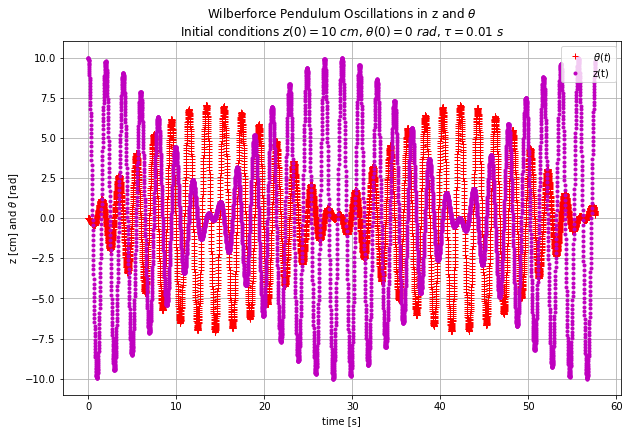

In [12]:
fig = plt.figure(figsize=(10.0, 6.5))
ax = fig.add_subplot()
ax.plot(tplot,thplot, '+r')
ax.plot(tplot,100*zplot,'.m') #convert z to centimeters to scale with theta range
ax.set_title(r'Wilberforce Pendulum Oscillations in z and $\theta$'
             '\n' 
             r'Initial conditions $z(0) = 10 \ cm$, $\theta (0) = 0 \ rad$, $\tau = 0.01 \ s$')
ax.grid(True)
ax.legend([r'$\theta (t)$','z(t)'], loc = 'upper right',
          frameon=True)
plt.xlabel('time [s]')
plt.ylabel(r'z [cm] and $\theta$ [rad]')
plt.show()

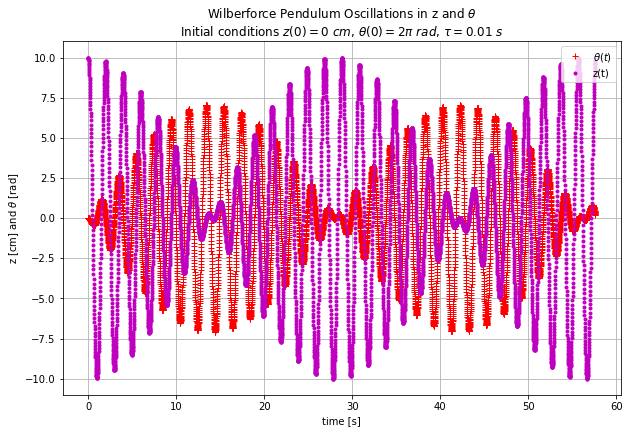

In [13]:
fig = plt.figure(figsize=(10.0, 6.5))
ax = fig.add_subplot()
ax.plot(tplot,thplot, '+r')
ax.plot(tplot,100*zplot,'.m') #convert z to centimeters to scale with theta range
ax.set_title(r'Wilberforce Pendulum Oscillations in z and $\theta$'
             '\n' 
             r'Initial conditions $z(0) = 0 \ cm$, $\theta (0) = 2 \pi \ rad$, $\tau = 0.01 \ s$')
ax.grid(True)
ax.legend([r'$\theta (t)$','z(t)'], loc = 'upper right',
          frameon=True)
plt.xlabel('time [s]')
plt.ylabel(r'z [cm] and $\theta$ [rad]')
plt.show()